In [1]:
import numpy as np
import pandas as pd
import sqlite3
from sqlite3 import Error
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, classification_report

In [2]:
### download the db from link in readme
db_path = "../../dbs/delays.db"

In [3]:
def create_connection(path):
    connection = None
    try:
        connection = sqlite3.connect(path)
        connection.text_factory = str
    except Error as e:
        print("Error occurred: " + str(e))
    return connection


def execute_query(connection, query):
    cursor = connection.cursor()
    try:
        if query == "":
            return "Query Blank"
        else:
            df = pd.read_sql_query(query, connection)
            return df
    except Error as e:
        return "Error occurred: " + str(e)

In [4]:
def onehot_encode(df, column_dict):
    df = df.copy()
    for column, prefix in column_dict.items():
        dummies = pd.get_dummies(df[column], prefix=prefix)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(column, axis=1)
    return df

In [5]:
def preprocess_inputs(df):
    df = df.copy()
    
    y = (df.ArrDelay>15).astype(int)
    
    
    df = df[['Year',
     'Month',
     'DayofMonth',
     'DayOfWeek',
     'IATA_CODE_Reporting_Airline',
     'OriginAirportID',
     'DestAirportID',
     'DepDelay',
     'AirTime',
     'Distance',
     'CarrierDelay',
     'WeatherDelay',
     'NASDelay',
     'SecurityDelay',
     'LateAircraftDelay']]
    

    
    # One-hot encode nominal feature columns
    X = onehot_encode(
        df,
        column_dict={
            'IATA_CODE_Reporting_Airline': 'AL',
            'OriginAirportID': 'OA',
            'DestAirportID': 'DA',
            'Year': 'Y',
            'Month': 'M',
            'DayofMonth': 'DM',
            'DayOfWeek': 'DW'
        }
    )
    

    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
    
    # Scale X with a standard scaler
    scaler = StandardScaler()
    scaler.fit(X_train)
    
    X_train = pd.DataFrame(scaler.transform(X_train), columns=X.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)
   
    return X_train, X_test, y_train, y_test

In [6]:
def evaluate_model(model, X_test, y_test):
    
    model_acc = model.score(X_test, y_test)
    print("Test Accuracy: {:.2f}%".format(model_acc * 100))
    
    y_true = np.array(y_test)
    y_pred = model.predict(X_test)
    
    cm = confusion_matrix(y_true, y_pred)
    clr = classification_report(y_true, y_pred, target_names=["Not Delayed", "Delayed"])
    
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
    plt.xticks(np.arange(2) + 0.5, ["Not Delayed", "Delayed"])
    plt.yticks(np.arange(2) + 0.5, ["Not Delayed", "Delayed"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    print("Classification Report:\n----------------------\n", clr)

In [7]:
sample_query = \
    """
        select 
         *
        from 
          delay 
        where 
          year= 2019
        limit 20000
    """

connection = create_connection(db_path)
data =  execute_query(connection, sample_query)

In [8]:
data

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,DOT_ID_Reporting_Airline,IATA_CODE_Reporting_Airline,Tail_Number,Flight_Number_Reporting_Airline,...,CRSElapsedTime,ActualElapsedTime,AirTime,Flights,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2019,1,1,4,5,2019-01-04,20304,OO,N945SW,5657,...,70,51,37,1,190,0,0,0,0,0
1,2019,1,1,4,5,2019-01-04,20304,OO,N932SW,5658,...,103,109,76,1,438,0,0,0,0,0
2,2019,1,1,4,5,2019-01-04,20304,OO,N932SW,5658,...,132,121,88,1,513,0,0,0,0,0
3,2019,1,1,4,5,2019-01-04,20304,OO,N916SW,5659,...,118,110,80,1,576,0,0,0,0,0
4,2019,1,1,4,5,2019-01-04,20304,OO,N107SY,5660,...,184,163,127,1,896,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,2019,1,1,29,2,2019-01-29,20304,OO,N284SY,3774,...,79,73,52,1,252,0,0,0,0,0
19996,2019,1,1,29,2,2019-01-29,20304,OO,N629BR,3775,...,106,131,63,1,411,0,0,25,0,45
19997,2019,1,1,29,2,2019-01-29,20304,OO,N291SY,3776,...,143,176,86,1,618,0,0,29,0,0
19998,2019,1,1,29,2,2019-01-29,20304,OO,N291SY,3777,...,165,151,124,1,733,0,104,0,0,18


In [9]:
X_train, X_test, y_train, y_test = preprocess_inputs(data)

In [10]:
X_train

,DepDelay,AirTime,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,AL_OO,OA_10135,...,DM_23,DM_27,DM_28,DM_29,DW_1,DW_2,DW_3,DW_5,DW_6,DW_7
0,-0.279359,-0.550561,-0.451429,-0.131705,-0.072803,-0.148694,-0.016693,-0.223333,0.0,-0.042295,...,-0.269047,-0.263199,2.780939,-0.203554,1.413229,-0.520793,-0.269047,-0.136478,-0.356289,-0.584389
1,-0.327546,0.472914,0.132829,-0.131705,-0.072803,-0.148694,-0.016693,-0.223333,0.0,-0.042295,...,3.716829,-0.263199,-0.359591,-0.203554,-0.707599,-0.520793,3.716829,-0.136478,-0.356289,-0.584389
2,-0.158890,-0.699818,-0.822150,-0.131705,-0.072803,-0.148694,-0.016693,-0.223333,0.0,-0.042295,...,-0.269047,-0.263199,-0.359591,-0.203554,1.413229,-0.520793,-0.269047,-0.136478,-0.356289,-0.584389
3,1.852947,0.302335,0.138760,2.438242,-0.072803,-0.148694,-0.016693,0.263488,0.0,-0.042295,...,-0.269047,-0.263199,-0.359591,4.912703,-0.707599,1.920150,-0.269047,-0.136478,-0.356289,-0.584389
4,-0.315500,0.792750,0.788264,-0.131705,-0.072803,0.304077,-0.016693,-0.223333,0.0,-0.042295,...,-0.269047,-0.263199,-0.359591,-0.203554,-0.707599,1.920150,-0.269047,-0.136478,-0.356289,-0.584389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13995,-0.231171,-0.913042,-0.964508,-0.131705,-0.072803,-0.148694,-0.016693,-0.223333,0.0,-0.042295,...,-0.269047,-0.263199,-0.359591,-0.203554,1.413229,-0.520793,-0.269047,-0.136478,-0.356289,-0.584389
13996,-0.207077,0.003821,-0.226030,-0.131705,-0.072803,-0.148694,-0.016693,-0.223333,0.0,-0.042295,...,-0.269047,-0.263199,-0.359591,-0.203554,1.413229,-0.520793,-0.269047,-0.136478,-0.356289,-0.584389
13997,-0.303453,-0.699818,-0.994165,-0.131705,-0.072803,-0.148694,-0.016693,-0.223333,0.0,-0.042295,...,-0.269047,-0.263199,-0.359591,-0.203554,1.413229,-0.520793,-0.269047,-0.136478,-0.356289,-0.584389
13998,-0.243218,-0.081468,-0.151886,-0.131705,-0.072803,-0.148694,-0.016693,-0.223333,0.0,-0.042295,...,-0.269047,-0.263199,-0.359591,-0.203554,-0.707599,-0.520793,-0.269047,-0.136478,2.806709,-0.584389


In [11]:
clf = LogisticRegression(random_state=42).fit(X_train, y_train)

/Users/ayush/Desktop/school/fp/env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Test Accuracy: 72.93%


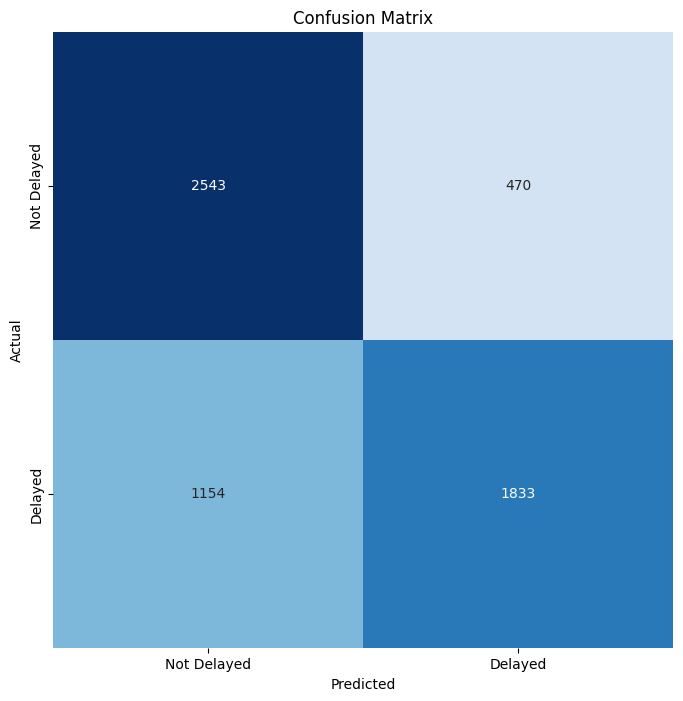

Classification Report:
----------------------
               precision    recall  f1-score   support

 Not Delayed       0.69      0.84      0.76      3013
     Delayed       0.80      0.61      0.69      2987

    accuracy                           0.73      6000
   macro avg       0.74      0.73      0.73      6000
weighted avg       0.74      0.73      0.73      6000



In [12]:
evaluate_model(clf, X_test, y_test)